In [4]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy.vector
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

### СОЗДАНИЕ МАКЕТА ДАННЫХ

In [5]:
# Создаю массив X c рандомными 5тью признаками и 100000 значениями и целевую переменную y
n_value = 100
n_features = 1

np.random.seed(100)
w_true = np.random.normal(size=(n_features+1,))

X = np.random.uniform(-5, 5, (n_value, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
X = np.column_stack((np.ones(X.shape[0]), X))

Y = X.dot(w_true) + np.random.normal(0, 1, n_value)
X = X[:, 1:]

# Определяю переменную с временем и добавляю её в массив X
date_list = np.array([datetime.datetime(2010, 1, 1) + datetime.timedelta(days=i) for i in range(n_value)])
# X = np.column_stack((date_list, X))

In [6]:
# plt.plot(X[:40, 0], y[:40]) # Первые 40 значений

# ПРЕДОБРАБОТКА

## Масштабирование
$ Z = \frac{x - \mu}{\sigma} $,
Где:
$Z$ - Z-оценка
$x$ - значение переменной
$\mu$ - среднее значение (математическое ожидание) генеральной совокупности
$\sigma$ - стандартное отклонение генеральной совокупност

In [7]:
def standard_scaler(data):
    """
    Масштабирование признаков с использованием Z-score
    :param data: np.ndarray - массив данных, который необходимо масштабировать
    :return: np.ndarray - масштабированный массив данных
    """
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scaled_data = (data - mean) / std
    return scaled_data

In [8]:
X = standard_scaler(X)

# РЕГРЕССИИ

## Обычная линейная регрессия
$\hat{\beta} = (X^T X)^{-1} X^T y$

Где:

$\hat{\beta}$ - оценка коэффициентов регрессии
$X$ - матрица признаков (дизайн-матрица), где каждая строка представляет отдельное наблюдение, а каждый столбец - признак
$y$ - вектор целевой переменной
$^T$ - оператор транспонирования матрицы
$^{-1}$ - оператор обратной матрицы

In [9]:
from sympy import *

In [10]:
class Linear_Regression(BaseEstimator):
    """
    Ванильная линейная регрессия
    """
    def __init__(self):
        self.coef = None
    def fit(self, X, y):
        X = np.column_stack((np.ones(X.shape[0]), X))
        self.coef = np.linalg.inv(X.T @ X) @ X.T @ y
    def predict(self, X):
        X = np.column_stack((np.ones(X.shape[0]), X))
        y_predict = X @ self.coef
        return y_predict

In [11]:
lr = Linear_Regression()
lr.fit(X, Y)

<Axes: >

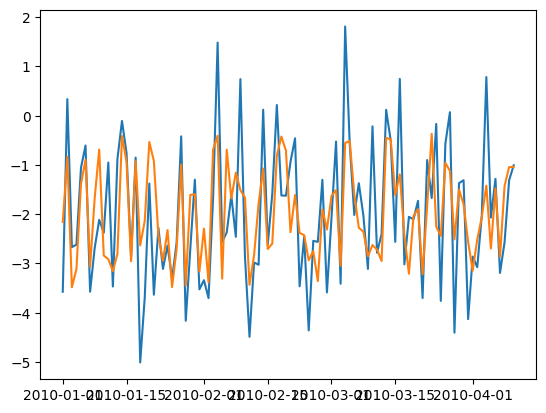

In [12]:
plt.figure()
sns.lineplot(x=date_list, y=Y)
sns.lineplot(x=date_list, y=lr.predict(X))

<Axes: >

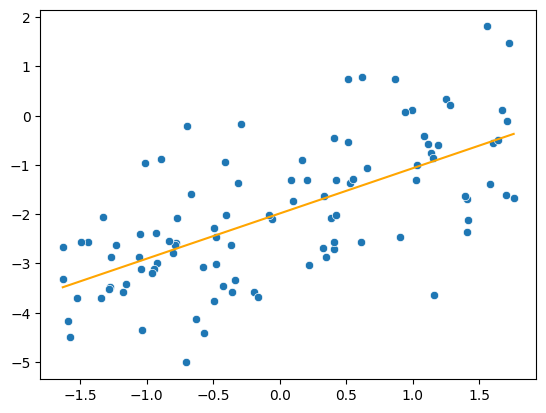

In [13]:
plt.figure()
sns.scatterplot(x=X[:, 0], y=Y)
sns.lineplot(x=X[:, 0], y=lr.predict(X), color='orange')

In [14]:
lr.coef

array([-1.98551436,  0.91981283])

## Ridge регрессия
$\hat{\beta} = (X^T X + \lambda I)^{-1} X^T y$

Где:

$\hat{\beta}$ - оценка коэффициентов регрессии
$X$ - матрица признаков (дизайн-матрица), где каждая строка представляет отдельное наблюдение, а каждый столбец - признак
$y$ - вектор целевой переменной
$^T$ - оператор транспонирования матрицы
$^{-1}$ - оператор обратной матрицы
$\lambda$ - коэффициент регуляризации
$I$ - единичная матрица

In [15]:
class Ridge_Regression(BaseEstimator):
    """
    Гребневая регрессия
    """
    def __init__(self):
        self.coef = None
    def fit(self, X, y, alpha=0.5):
        X = np.column_stack((np.ones(X.shape[0]), X))
        # Создаю единичную матрицу
        I = np.identity(X.shape[1])
        I[0, 0] = 0
        self.coef = (np.linalg.inv((X.T @ X) + (I * alpha)) @ X.T) @ y
    def predict(self, X):
        X = np.column_stack((np.ones(X.shape[0]), X))
        y_predict = X @ self.coef
        return y_predict

In [16]:
rr = Ridge_Regression()
rr.fit(X, Y, alpha=100)

<Axes: >

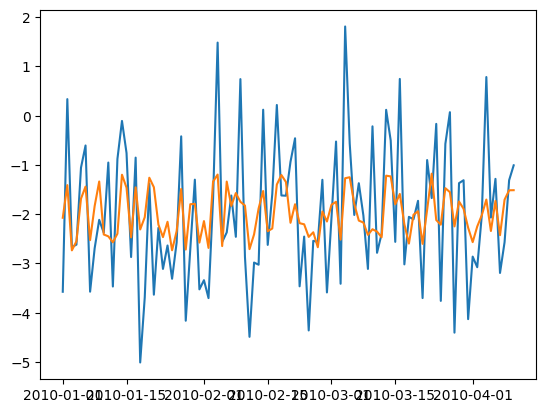

In [17]:
plt.figure()
sns.lineplot(x=date_list, y=Y)
sns.lineplot(x=date_list, y=rr.predict(X))

<Axes: >

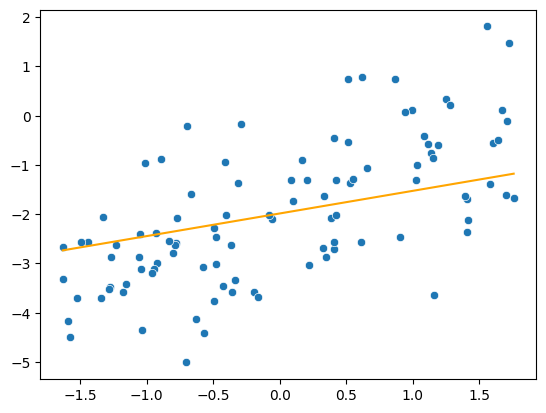

In [18]:
plt.figure()
sns.scatterplot(x=X[:, 0], y=Y)
sns.lineplot(x=X[:, 0], y=rr.predict(X), color='orange')

In [19]:
rr.coef

array([-1.98551436,  0.45990641])

# Градиентный спуск

## Full GD

In [20]:
l, j, n = symbols('l j n', integer=True)
x = MatrixSymbol("X", l, j)
w = MatrixSymbol("w", j, 1)
y = MatrixSymbol("y", l, 1)
# Определяем функцию MSE в матричной форме
mse = 1 / l * (y - x * w).T * (y - x * w)
# Вычисляем градиент по w
grad_w = diff(mse, w)
grad_w

(-2/l)*X.T*(-X*w + y)

In [21]:
def get_gradient(X, y, w):
    return (2/X.shape[0]) * (X.T @ ((X @ w) - y))

class FullGD(BaseEstimator):

    def __init__(self, max_steps = 200, min_step_len = 1e-20):
        self.w = None
        self.w0 = None
        self.max_steps = max_steps
        self.min_step_len = min_step_len
        self.w_history = []

    def fit(self, X, y, w0 = None):
        # Добавляем единичный столбец
        X = np.column_stack((np.ones(X.shape[0]), X))

        # Если не указаны веса для первой итерации, обозначаем их как нули
        if w0 is None:
            self.w0 =  np.zeros(X.shape[1])

        # Реализуем градиентный спуск
        step_num = 0
        w_history = []
        while step_num <= self.max_steps:
            # Если шаг является первым, используем нулевые веса как веса предыдущей итерации
            if step_num == 0:
                old_w = self.w0
                epsilon = 1
            else:
                old_w = w
                epsilon = 1/step_num


            w = old_w - epsilon * get_gradient(X, y, old_w)
            w_history.append(w)

            step_len = np.linalg.norm(w - old_w)

            if step_len <= self.min_step_len:
                break

            step_num += 1

        self.w_history = w_history
        self.w = w

    def predict(self, X):
        # Добавляем единичный столбец
        X = np.column_stack((np.ones(X.shape[0]), X))

        return X @ self.w

In [22]:
gd = FullGD()
gd.fit(X, Y)

<Axes: >

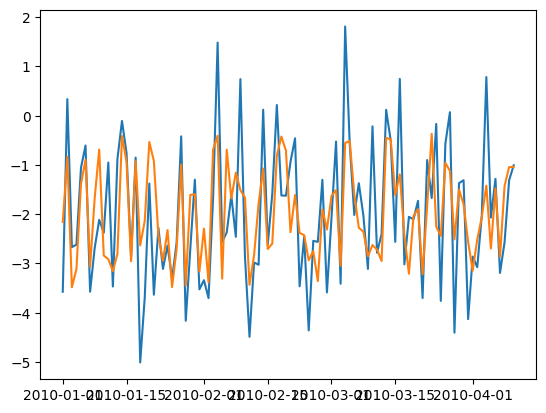

In [23]:
plt.figure()
sns.lineplot(x=date_list, y=Y)
sns.lineplot(x=date_list, y=gd.predict(X))

<Axes: >

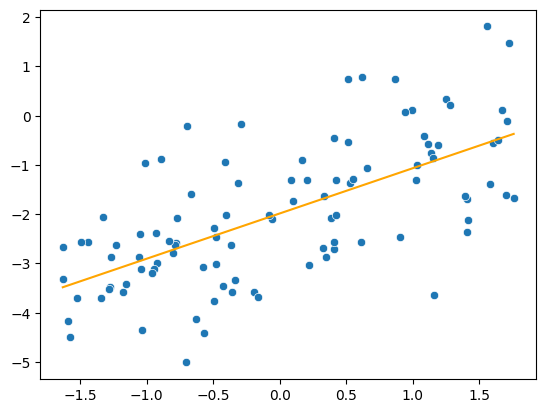

In [24]:
plt.figure()
sns.scatterplot(x=X[:, 0], y=Y)
sns.lineplot(x=X[:, 0], y=gd.predict(X), color='orange')